In [8]:
import sys
sys.path.append('../')

import os

import cqt
import cqt.env.mkt_env as env 
import cqt.env.mkt_env_spot as envspot
import cqt.ledger.ledger as ledger
import cqt.strats.strategy as stg
import cqt.strats.strategy_long_short_average as stg_ls
import pandas as pd
import pickle

from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
os.listdir('../data/pickle')


['coinapi_coinapi-ohlcv-GEMINI_SPOT_BTC_USD-1DAY_data.pickle',
 'coinapi_ohlcv_BINANCE_SPOT_BTC_USDT_1DAY_data.pickle',
 'coinapi_ohlcv_GEMINI_SPOT_BTC_USD_1DAY_data.pickle',
 'coinapi_ohlcv_GEMINI_SPOT_BTC_USD_1HRS_data.pickle',
 'coinapi_ohlcv_GEMINI_SPOT_ETH_USD_1DAY_data.pickle',
 'coinapi_ohlcv_GEMINI_SPOT_ETH_USD_1HRS_data.pickle',
 'gdax_products_BTC-USD_data.pickle',
 'model_btc_eth.pickle']

In [4]:
outDir = '../performance_tracking'
if not os.path.exists(outDir):
    os.makedirs(outDir)
    print(outDir)

In [5]:
pickleFileDir = '../data/pickle'
# btcFileName = 'coinapi_ohlcv_GEMINI_SPOT_BTC_USD_1MIN_data.pickle'
# btcFilePath = os.path.join(pickleFileDir, btcFileName)
# file_btc_eth = open(btcFilePath,'rb')

file_btc = '../data/pickle/coinapi_ohlcv_GEMINI_SPOT_BTC_USD_1DAY_data.pickle'
df_btc = pd.read_pickle(file_btc)
file_eth = '../data/pickle/coinapi_ohlcv_GEMINI_SPOT_eth_USD_1DAY_data.pickle'
df_eth = pd.read_pickle(file_eth)


In [13]:
config = {'asset_type': 'spot'}
comp_btc = envspot.MktEnvSpot('btc', df_btc, config)
comp_eth = envspot.MktEnvSpot('eth', df_eth, config)

model_btc_eth = env.MktEnv([])
model_btc_eth.insert_section(comp_btc)
model_btc_eth.insert_section(comp_eth)
# model_btc_eth = pickle.load(open(os.path.join(pickleFileDir, 'model_btc_eth.pickle'), 'rb'))
# os.listdir('../data/pickle')
# model_btc_eth.

In [14]:
# init portfolio

cash = 10000
assets = {'btc': 0, 'eth': 0}
ini_pfo = ledger.Ledger(assets, cash)

In [15]:
comp_btc.target

'btc'

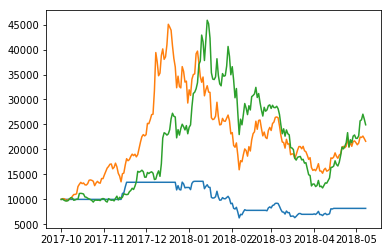

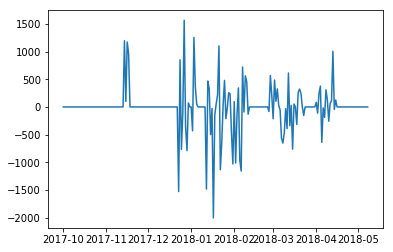

In [17]:
# Long/Short Average
ls_rule = {'method' : 'moving_average', 'window_size' : [3, 5], 'tolerance_up' : 0.03, 'tolerance_down' : 0.03}
strats = stg_ls.StrategySimpleMA(model_btc_eth, ini_pfo, ls_rule)
start_date_str = '2017-10-01'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
report = strats.back_testing(start_date)

longShortReport = report.copy()

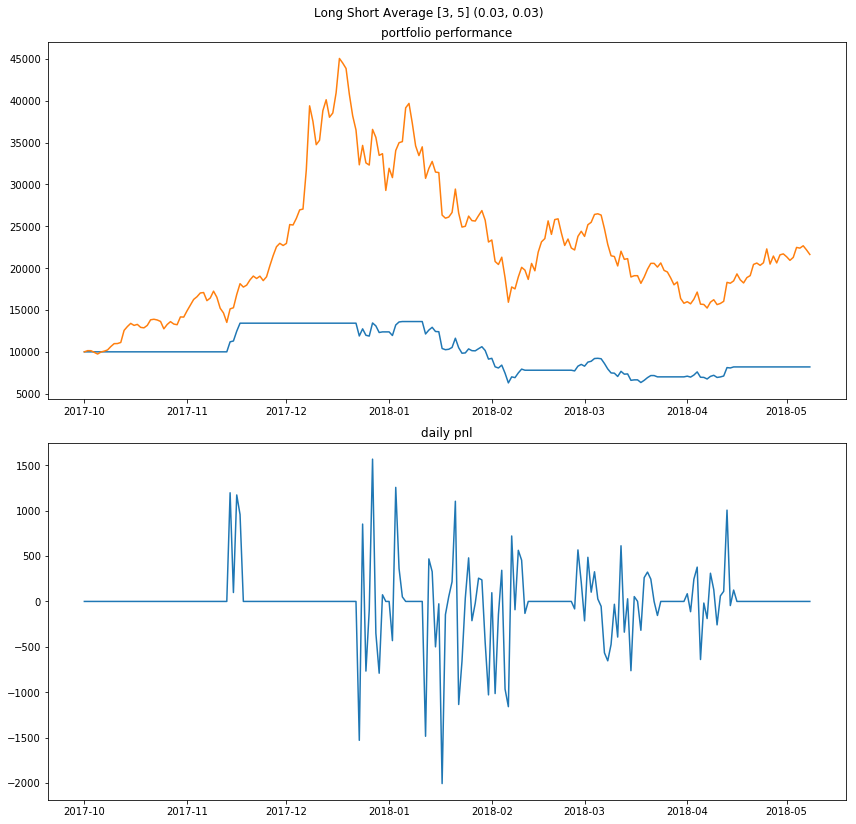

max daily gain: 1566.9017086617769
max daily loss: -2005.7462346636767


In [18]:
report = longShortReport
strategyName = 'Long Short Average [3, 5] (0.03, 0.03)'
report.to_csv(os.path.join(outDir, strategyName+'.csv'), index=False)
fig_width = 12
fig_height = 12
fig, ax0 = plt.subplots(2,1, figsize=(fig_width,fig_height))
ax0[0].plot(report['date'], report['total'])
ax0[0].plot(report['date'], report['btc_price'] * cash / report['btc_price'][0])
ax0[0].set_title('portfolio performance')
ax0[1].plot(report['date'], report['pnl'])
ax0[1].set_title('daily pnl')
fig.suptitle(strategyName)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.savefig(os.path.join(outDir, strategyName+'.pdf'))
plt.show()

print('max daily gain:', report['pnl'].max())
print('max daily loss:', report['pnl'].min())

In [21]:
from cqt.analyze.signal_double_dip import signal_double_dip as sdd

class StrategyTest(stg.Strategy):
    def apply_event_logic(self, time, prtf):
        btc = 'btc'
        if self.env.has_section(btc):            
            comp_btc = self.env.get_section(btc)
            ind_btc = sdd(self.env, btc, time, self.rules)
            price_btc = comp_btc.get_price_close(time)
            
            if ind_btc == 1:
                prtf.buy(btc, price_btc)
            else:
                prtf.sell(btc, price_btc)         
        return prtf

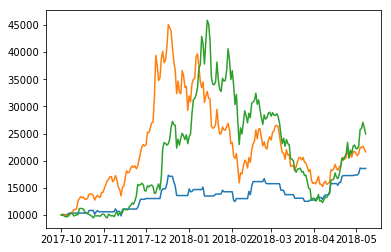

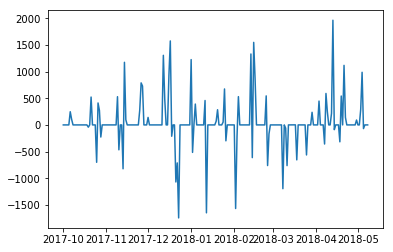

In [22]:
dd_rule = {'method' : 'moving_average', 'window_size' : [3, 5], 'tolerance_up' : 0.03, 'tolerance_down' : 0.03}
strats = StrategyTest(model_btc_eth, ini_pfo, dd_rule)
start_date_str = '2017-10-01'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
report = strats.back_testing(start_date)
doubleDipReport = report.copy()

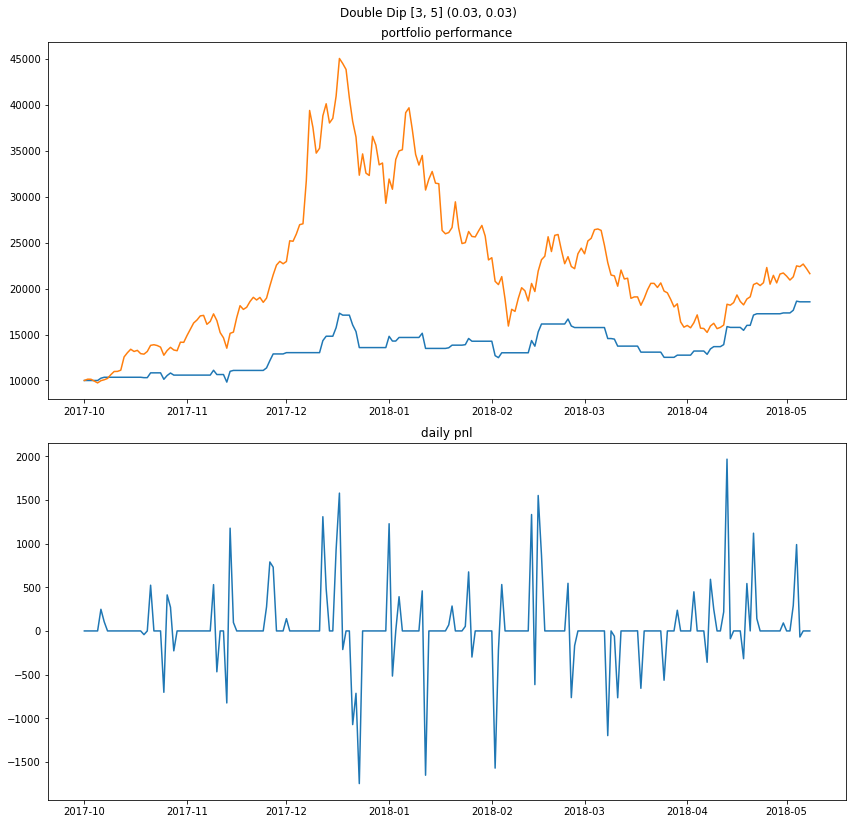

max daily gain: 1965.403614631041
max daily loss: -1746.348299388017


In [23]:
strategyName = 'Double Dip [3, 5] (0.03, 0.03)'
report = doubleDipReport
report.to_csv(os.path.join(outDir, strategyName+'.csv'), index=False)
fig_width = 12
fig_height = 12
fig, ax0 = plt.subplots(2,1, figsize=(fig_width,fig_height))
ax0[0].plot(report['date'], report['total'])
ax0[0].plot(report['date'], report['btc_price'] * cash / report['btc_price'][0])
ax0[0].set_title('portfolio performance')
ax0[1].plot(report['date'], report['pnl'])
ax0[1].set_title('daily pnl')
fig.suptitle(strategyName)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.savefig(os.path.join(outDir,strategyName+'.pdf'))
plt.show()

print('max daily gain:', report['pnl'].max())
print('max daily loss:', report['pnl'].min())

In [ ]:
# class StrategyBuyTheDips(stg.Strategy):
#     def apply_event_logic(self, ticker = 'btc', time, prtf):
#         if self.asset_model.has_component(ticker):            
#             asset_comp = self.asset_model.get_component(ticker)
#             ind_btc = comp_btc.signal_double_dip(time, self.rules)
#             price_btc = comp_btc.get_price_close(time)
            
#             if ind_btc == 1:
#                 prtf.buy(btc, price_btc)
#             else:
#                 prtf.sell(btc, price_btc)         
#         return prtf

In [ ]:
# # Long/Short Average

# ls_rule = {'method' : 'moving_average', 'window_size' : [3, 5], 'tolerance_up' : 0.03, 'tolerance_down' : 0.03}
# strats = stg_ls.StrategyLongShortAverage(model_btc_eth, ini_pfo, ls_rule)
# start_date_str = '2017-10-01'
# start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
# report = strats.back_testing(start_date)

# plt.plot(report['date'], report['total'])
# plt.plot(report['date'], report['btc_price'] * cash / report['btc_price'][0])
# plt.show()
# plt.plot(report['date'], report['pnl'])
# plt.show()

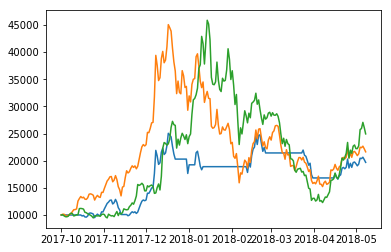

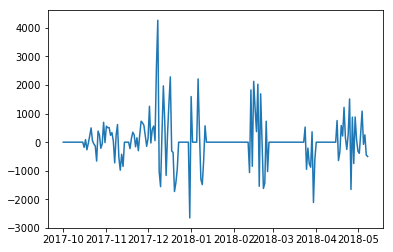

In [25]:
# Long/Short Average

ls_rule = {'method' : 'moving_average', 'window_size' : [3, 5], 'tolerance_up' : 0.03, 'tolerance_down' : 0.03}
strats = stg_ls.StrategyInverseMA(model_btc_eth, ini_pfo, ls_rule)
start_date_str = '2017-10-01'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
report = strats.back_testing(start_date)
inverseLongShortAverageReport = report.copy()

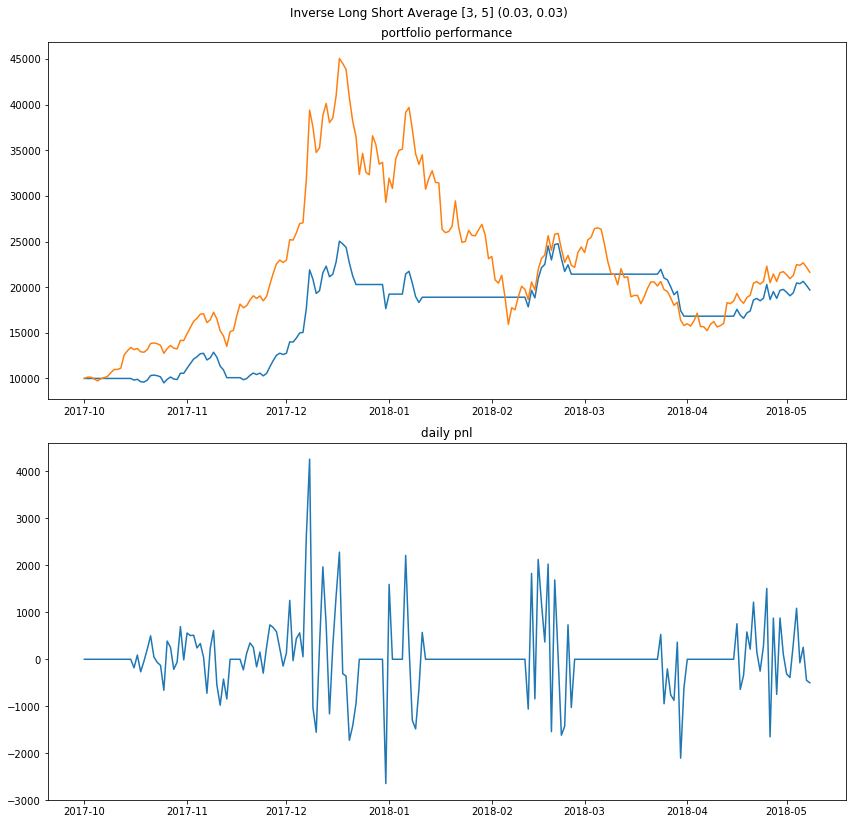

max daily gain: 4257.354288080522
max daily loss: -2644.368031884762


In [26]:
report = inverseLongShortAverageReport
strategyName = 'Inverse Long Short Average [3, 5] (0.03, 0.03)'
report.to_csv(os.path.join(outDir, strategyName+'.csv'), index=False)
fig_width = 12
fig_height = 12
fig, ax0 = plt.subplots(2,1, figsize=(fig_width,fig_height))
ax0[0].plot(report['date'], report['total'])
ax0[0].plot(report['date'], report['btc_price'] * cash / report['btc_price'][0])
ax0[0].set_title('portfolio performance')
ax0[1].plot(report['date'], report['pnl'])
ax0[1].set_title('daily pnl')
fig.suptitle(strategyName)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.savefig(os.path.join(outDir, strategyName+'.pdf'))
plt.show()

print('max daily gain:', report['pnl'].max())
print('max daily loss:', report['pnl'].min())